In [4]:
# Common modules
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Decision tree specific modules
from sklearn import tree

from scipy.sparse import load_npz

from sklearn.feature_extraction.text import CountVectorizer #Can use tfidffvectorizer as well
import pandas as pd 
import os
import re
import numpy as np

from matplotlib import pyplot as plt
from collections import defaultdict, Counter

In [5]:
BASE_PATH = os.path.join(os.getcwd(), os.pardir)
DATA_PATH = os.path.join(BASE_PATH, 'data')

In [6]:
X_train = load_npz(os.path.join(DATA_PATH, 'training_feats.npz'))

In [7]:
X_test = load_npz(os.path.join(DATA_PATH, 'test_feats.npz'))

In [8]:
X_train.shape

(49308, 35522)

In [9]:
X_test.shape

(74659, 35522)

In [10]:
train_df = pd.read_json(os.path.join(BASE_PATH, '01-milestone1', 'imputed_train.json'))
test_df =  pd.read_json(os.path.join(DATA_PATH, 'test.json.zip'))

In [11]:
y_train = train_df['interest_level']

In [12]:
X_test_indexes = test_df.listing_id

# Preprocessing
As described in milestone 1, we will do some feature extraction.


## Training the model

We first instantiate a decision tree model and train it naively using all the features.

In [13]:
# Convert labels from {low, medium high} -> {0, 1, 2}
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)

## Train-test split

We need to split the training data into a training set and a validation set (to evaluate the performance of the model).

For now we do 5-fold cross_validation.

In [11]:
seed = 36201431

Our initial approach is to use all features for training. For the parameters, we simply use the defaults.

In [12]:
model = tree.DecisionTreeClassifier()
scores = cross_validate(model, X_train, y_train, scoring='neg_log_loss', cv=5, return_train_score=True)
# Convert negative log loss to log loss
test_scores = -1 * scores['test_score']
train_scores = -1 * scores['train_score']

score = test_scores.mean().round(4)
train_score = train_scores.mean().round(4)

NameError: name 'n_feat' is not defined

In [13]:

print("Mean log loss test  score: {0}".format(score))
print("Mean log loss train score: {0}".format(train_score))

Mean log loss test  score: 11.19
Mean log loss train score: 0.0


Now we can try training on the entire train set. We will obtain a model, train it on the test dataset, then submit to kaggle for evaluation.

In [14]:
model = tree.DecisionTreeClassifier(criterion='gini')
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [15]:
y_pred = model.predict_proba(X_test)

In [16]:
le.classes_

array(['high', 'low', 'medium'], dtype=object)

Since the order is not correct (low corresponds to the label 1, but in the csv they expect the low to be the third column), we must swap columns for y_pred.

There may be a "bug" below, I don't think I actually swapped the columns yet.

In [14]:
def create_submission_csv(y_pred, X_test_indexes):
    df = pd.DataFrame(y_pred, columns=le.classes_)
    df.index = X_test_indexes
    df.index.name = 'listing_id'
    return df

In [27]:
output = create_submission_csv(y_pred, X_test_indexes)
output.to_csv('decision_tree_predictions_1.csv')

# Score from Kaggle
9.18820 <- ignore, this is the old score

In [20]:
output.shape

(74659, 3)

## Attempt 2

It seems that using all the features is not very good. Let's use a smaller set of features.
We can choose the top x features in order of descending mutual information (wrt the label).

In [28]:
n_feats = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 35520]

In [29]:
cross_val_scores = {}

In [30]:
mutual_info = mutual_info_classif(X_train, y_train, random_state=seed)

In [32]:
# n_feat = 50
# top_features = mutual_info.argsort()[-1 * n_feat:][::-1]

# # Only use these top n features when training, to eliminate overfitting.
# X_train_final = X_train[:,top_features]

# model = tree.DecisionTreeClassifier()
# scores = cross_validate(model, X_train_final, y_train, scoring='neg_log_loss', cv=5, return_train_score=True)
# # Convert negative log loss to log loss
# test_scores = -1 * scores['test_score']
# train_scores = -1 * scores['train_score']
# score = test_scores.mean().round(4)
# train_score = train_scores.mean().round(4)
# print("Mean log loss test  score using top {0} features: {1}".format(n_feat, score))
# print("Mean log loss train score using top {0} features: {1}".format(n_feat, train_score))

Mean log loss test  score using top 50 features: 11.9486
Mean log loss train score using top 50 features: 0.0013


In [32]:
best_score = 9999999999999999
best_train_score = 9999999999999
best_n = 0

for n_feat in n_feats:
    print("Considering top {0} features.".format(n_feat))
    top_features = mutual_info.argsort()[-1 * n_feat:][::-1]

    # Only use these top n features when training, to eliminate overfitting.
    X_train_final = X_train[:,top_features]
    
    model = tree.DecisionTreeClassifier()
    scores = cross_validate(model, X_train_final, y_train, scoring='neg_log_loss', cv=5, return_train_score=True)
    # Convert negative log loss to log loss
    test_scores = -1 * scores['test_score']
    train_scores = -1 * scores['train_score']

    score = test_scores.mean().round(4)
    train_score = train_scores.mean().round(4)
    
    cross_val_scores[n_feat] = {
        'train': train_score,
        'test': score
    }
    
    print("Mean log loss score using top {0} features: {1}".format(n_feat, score))
    print("Mean log loss train score using top {0} features: {1}".format(n_feat, train_score))
    
    cross_val_scores[n_feat] = score
    
    if score < best_score:
        best_score = score
        best_train_score = train_score
        best_n = n_feat

print("The best number of features is {0}".format(best_n))
print("The log loss for this number of features is {0}".format(best_score))
print("The training log loss for this number of features is {0}".format(best_train_score))

Considering top 10 features.
Mean log loss score using top 10 features: 12.2594
Mean log loss train score using top 10 features: 0.0145
Considering top 20 features.
Mean log loss score using top 20 features: 11.4878
Mean log loss train score using top 20 features: 0.0135
Considering top 50 features.
Mean log loss score using top 50 features: 11.7795
Mean log loss train score using top 50 features: 0.0012
Considering top 100 features.
Mean log loss score using top 100 features: 11.9161
Mean log loss train score using top 100 features: 0.0012
Considering top 200 features.
Mean log loss score using top 200 features: 11.6987
Mean log loss train score using top 200 features: 0.0008
Considering top 500 features.
Mean log loss score using top 500 features: 11.6289
Mean log loss train score using top 500 features: 0.0008
Considering top 1000 features.
Mean log loss score using top 1000 features: 11.4237
Mean log loss train score using top 1000 features: 0.0008
Considering top 2000 features.
Me

In [29]:
train_scores_for_n = [ 0.0145, 0.0135, 0.0012, 0.0012, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0002, 0]
test_scores_for_n = [12.2594, 11.4878, 11.7795, 11.9161, 11.6987, 11.6289, 11.4237, 11.4985, 11.2345, 11.2097, 11.1606 ]
x_range = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 35520]

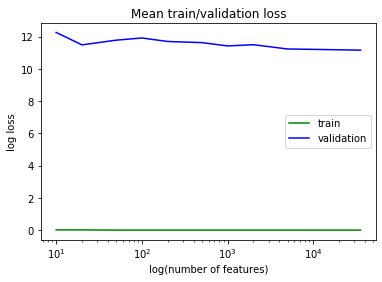

In [32]:
plt.plot(x_range, train_scores_for_n, 'g', label='train')
plt.plot(x_range, test_scores_for_n, 'b', label='validation')
plt.legend()
plt.xlabel('log(number of features)')
plt.ylabel('log loss')
plt.xscale('log')
plt.title('Mean train/validation loss')
plt.show()

In [ ]:
# Train on entire dataset
X_train_final = X_test[:,best_n]
X_test_final = X_test[:,best_n]

model = tree.DecisionTreeClassifier(criterion='gini')
model.fit(X_train_final, y_train)

y_pred = model.predict_proba(X_test_final)

output = create_submission_csv( y_pred, X_test_indexes)
output.to_csv('decision_tree_predictions_2.csv')

# Attempt 3
Clearly something is wrong with using the 35,000+ features, which includes the following:
* Description word counts
* Feature word counts
* One hot encodings for building id, manager id
* Year, month, day, etc.

One thing we can try is reduce the number of features to choose from. We can try excluding the above.

In [16]:
def preprocess(train_df, min_feats=5):
    bathrooms = train_df['bathrooms']
    bedrooms = train_df['bedrooms']
#     building_ids = train_df['building_id']
    latitudes = train_df['latitude']
    longitudes = train_df['longitude']
#     manager_ids = train_df['manager_id']
    prices = train_df['price']
    
    datetime = pd.to_datetime(train_df['created'])
    
    months = datetime.dt.month
    days = datetime.dt.day
    hours = datetime.dt.hour
    
    # Where Monday = 0, and Sunday = 6
    weekdays = datetime.dt.dayofweek
    
    num_photos = train_df['photos'].str.len()
    
    # The final dataframe to be returned
    final_train_df = pd.DataFrame()
    
    final_train_df['bathrooms'] = bathrooms
    final_train_df['bedrooms'] = bedrooms
#     final_train_df['building_ids'] = building_ids 
    final_train_df['latitudes'] = latitudes
    final_train_df['longitudes'] = longitudes
#     final_train_df['manager_ids'] = manager_ids
    final_train_df['prices'] = prices
    
    final_train_df['months'] = months
    final_train_df['days'] = days
    final_train_df['hours'] = hours
    
    final_train_df['weekdays'] = weekdays
    final_train_df['num_photos'] = num_photos
    final_train_df.index = train_df['listing_id']

    return final_train_df
    

In [17]:
X_train2 = train_df.drop(columns=['interest_level'])
X_test2 = test_df
X_train2 = preprocess(X_train2)
X_test2 = preprocess(X_test2)
drop_cols = ['num_photos', 'months', 'days', 'hours', 'weekdays']
X_train2 = X_train2.drop(columns=drop_cols)
X_test2 = X_test2.drop(columns=drop_cols)

The number of features is rather small, but at least it is clean. Let's try cross-validation again.

In [45]:
model = tree.DecisionTreeClassifier()
scores = cross_validate(model, X_train2, y_train, scoring='neg_log_loss', cv=5, return_train_score=True)

# Convert negative log loss to log loss
test_scores = -1 * scores['test_score']
train_scores = -1 * scores['train_score']
score = test_scores.mean().round(4)
train_score = train_scores.mean().round(4)

print("Mean log loss test  score: {0}".format(score))
print("Mean log loss train score: {0}".format( train_score))

Mean log loss test  score: 9.667
Mean log loss train score: 0.1439


In [46]:
# Train on entire dataset
model = tree.DecisionTreeClassifier(criterion='gini')
model.fit(X_train2, y_train)

y_pred = model.predict_proba(X_test2)

output = create_submission_csv(y_pred, X_test_indexes)
output.to_csv('decision_tree_predictions_2.csv')

# Attempt 4

If reducing the number of features is not working out, then we should find other ways to reduce overfitting. Pruning is known to be a well-known method for doing so.

- entropy for information gain
- limiting max_depth to like 30 or so
- class_weight = balanced
- ccp_alpha = ??? 

In [47]:
n_features = X_train.shape[1]

In [87]:
# Train on entire dataset
model = tree.DecisionTreeClassifier(criterion='gini')
model.fit(X_train2, y_train)
path = model.cost_complexity_pruning_path(X_train2, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_alphas

array([ 0.00000000e+00, -9.03501810e-21, -6.77626358e-21, ...,
        5.23884245e-03,  5.86846096e-03,  1.32798860e-02])

In [90]:
np.max(ccp_alphas)

0.013279886031082988

# Grid Search for optimal parameters

Because of overfitting, we will use a relatively small number of features.

In [48]:

parameters = {
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced'],
    'min_samples_leaf': [1, 2, 3],
    'splitter': ['best', 'random'],
    'ccp_alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e-0]
}

In [49]:
model = tree.DecisionTreeClassifier()
clf = GridSearchCV(model, parameters, scoring='neg_log_loss', cv=5, return_train_score=True)

In [50]:
result = clf.fit(X_train2, y_train)

ValueError: Invalid parameter ccp_alpha for estimator DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'). Check the list of available parameters with `estimator.get_params().keys()`.

In [100]:
result

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'ccp_alpha': [1e-10, 1e-08, 1e-06, 0.0001, 0.01, 1.0]

In [102]:
clf.best_params_

{'ccp_alpha': 0.0001,
 'class_weight': None,
 'criterion': 'gini',
 'min_samples_leaf': 1,
 'splitter': 'best'}

In [104]:
clf.best_score_

-0.7071378632561878

In [108]:
clf.cv_results_['mean_test_score']

array([-10.93096494, -11.01497057,  -8.23351146,  -6.60870272,
        -6.48554245,  -4.47055091, -10.8981956 , -11.09059213,
        -8.43868869,  -6.66221713,  -6.56497346,  -4.40287725,
       -10.86231038, -11.09500554,  -8.19771318,  -6.60693549,
        -6.32698222,  -4.49447195, -10.87787802, -11.03222916,
        -8.43636246,  -6.63343241,  -6.51069618,  -4.50861596,
       -10.91117473, -11.06000583,  -8.26901721,  -6.60050439,
        -6.44929852,  -4.37457586, -10.8664666 , -11.05011638,
        -8.42288085,  -6.57829861,  -6.58823577,  -4.43674298,
       -10.86963002, -10.94969721,  -8.21022264,  -6.61941576,
        -6.32649461,  -4.44401239, -10.8817089 , -11.03485412,
        -8.46307988,  -6.66704472,  -6.50040007,  -4.52790285,
       -10.90011216, -11.05470673,  -8.25930225,  -6.62615696,
        -6.47050781,  -4.33358343, -10.90297845, -11.12776446,
        -8.45078019,  -6.55836522,  -6.54996847,  -4.36474493,
       -10.86620585, -11.12616466,  -8.22041202,  -6.58

In [39]:
model = tree.DecisionTreeClassifier(criterion='gini', ccp_alpha=0, class_weight=None,
                                   min_samples_leaf=1, splitter='best')
scores = cross_validate(model, X_train2, y_train, scoring='neg_log_loss', cv=5, return_train_score=True)

# Convert negative log loss to log loss
test_scores = -1 * scores['test_score']
train_scores = -1 * scores['train_score']
score = test_scores.mean().round(4)
train_score = train_scores.mean().round(4)
print("Mean log loss test  score  {0}".format(score))
print("Mean log loss train score  {0}".format(train_score))

Mean log loss test  score  9.6809
Mean log loss train score  0.1439


In [40]:
# Train on entire dataset

model = tree.DecisionTreeClassifier(criterion='gini', ccp_alpha=0, class_weight=None,
                                   min_samples_leaf=1, splitter='best')
model.fit(X_train2, y_train)

y_pred = model.predict_proba(X_test2)

output = create_submission_csv(y_pred, X_test_indexes)
output.to_csv('decision_tree_predictions_4.csv')

In [18]:
# Train on entire dataset

model = tree.DecisionTreeClassifier(criterion='gini', ccp_alpha=0.0001, class_weight=None,
                                   min_samples_leaf=1, splitter='best')
model.fit(X_train2, y_train)

y_pred = model.predict_proba(X_test2)

output = create_submission_csv(y_pred, X_test_indexes)
output.to_csv('decision_tree_predictions_3.csv')